In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Embedding, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
y_train = tf.keras.utils.to_categorical(y_train, 10)  # One-hot encode labels


In [2]:
def build_generator():
    noise_dim = 100
    label_dim = 10
    model = Sequential()

    # Noise input
    noise_input = tf.keras.Input(shape=(noise_dim,))
    # Label input
    label_input = tf.keras.Input(shape=(label_dim,))

    # Concatenate noise and label
    merged_input = Concatenate()([noise_input, label_input])

    # Fully connected layers
    x = Dense(7 * 7 * 256, use_bias=False)(merged_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 256))(x)

    # Convolutional layers
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    model = Model([noise_input, label_input], x)
    return model


In [3]:
def build_discriminator():
    img_shape = (28, 28, 1)
    label_dim = 10
    model = Sequential()

    # Image input
    img_input = tf.keras.Input(shape=img_shape)
    # Label input
    label_input = tf.keras.Input(shape=(label_dim,))
    label_embedding = Dense(np.prod(img_shape), use_bias=False)(label_input)
    label_embedding = Reshape(img_shape)(label_embedding)

    # Concatenate image and label
    merged_input = Concatenate()([img_input, label_embedding])

    # Convolutional layers
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(merged_input)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model([img_input, label_input], x)
    return model


In [4]:
# Create the models
generator = build_generator()
discriminator = build_discriminator()

# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Define the optimizers
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)


In [12]:
import tensorflow as tf
@tf.function
def train_step(image_label_tuple):
    images, labels = image_label_tuple
    noise_dim = 100
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Calculate gradients 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # applying the calculated gradients above
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


# Training function
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_label_tuple in dataset:
            gen_loss, disc_loss = train_step(image_label_tuple)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')



In [22]:
# Prepare the dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 5

# Create batches
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train the cGAN
train(train_dataset, EPOCHS)

Epoch 1, Gen Loss: 1.115477442741394, Disc Loss: 1.215847373008728
Epoch 2, Gen Loss: 1.1391178369522095, Disc Loss: 1.0501047372817993
Epoch 3, Gen Loss: 0.9661871194839478, Disc Loss: 1.1393492221832275
Epoch 4, Gen Loss: 1.1377681493759155, Disc Loss: 1.0886088609695435
Epoch 5, Gen Loss: 0.9971925616264343, Disc Loss: 1.2454900741577148


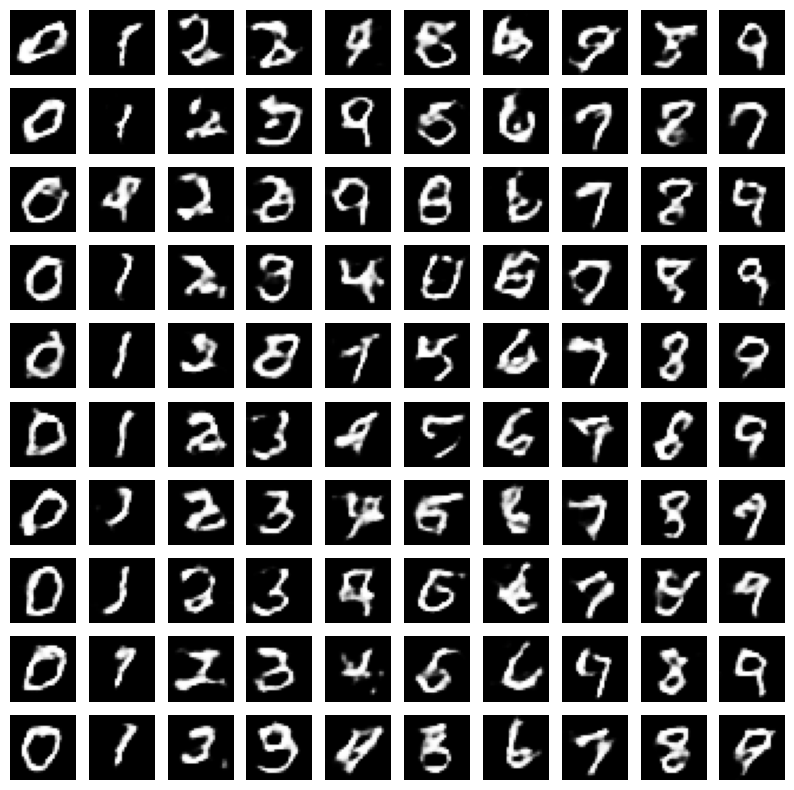

In [23]:
def generate_images(model, epoch, test_input, test_labels):
    predictions = model([test_input, test_labels], training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

# Generate and save images
num_examples_to_generate = 100
test_noise = tf.random.normal([num_examples_to_generate, 100])
test_labels = tf.one_hot(np.array([i % 10 for i in range(num_examples_to_generate)]), depth=10)

generate_images(generator, EPOCHS, test_noise, test_labels)
